# Predicting Apartment Prices in Mexico City

Data card: https://www.kaggle.com/datasets/allankirwa/mexico-city-real-estate-dataset

## Preparing the Data

### Import

In [1]:
!pip install category_encoders

In [2]:
import category_encoders as ce

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from glob import glob
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

import warnings 

In [4]:
# Building `wrangle` function
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Distrito Federal", less than 100,000
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop features with high null counts
    df.drop(columns = ["floor", "expenses"], inplace=True)
    
    # Drop low and high cardinality categorical variables
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)
    
    # Drop leaking columns(leakage variables)
    df.drop(
        columns= [
            'price',
            'price_aprox_local_currency',
            'price_per_m2',
            'price_usd_per_m2'
        ], 
        inplace = True
    )
    
    # Drop columns with multicolinearity 
    df.drop(columns=["rooms", "surface_total_in_m2"], inplace=True)
    
    # Drop index column
    df.drop(columns=df.columns[0], inplace=True)
            
    return df

In [5]:
# Using glob to create a list 'files' (list comprehension) to automate process (reading CSV files into a Data Frame)
files = glob("/Users/susiechen/Documents/Personal_Project_Data/WorldQuantUni/1_2_Mexico_real_estate/mexico-city-real-estate-*.csv")
files

['/Users/susiechen/Documents/Personal_Project_Data/WorldQuantUni/1_2_Mexico_real_estate/mexico-city-real-estate-5.csv',
 '/Users/susiechen/Documents/Personal_Project_Data/WorldQuantUni/1_2_Mexico_real_estate/mexico-city-real-estate-4.csv',
 '/Users/susiechen/Documents/Personal_Project_Data/WorldQuantUni/1_2_Mexico_real_estate/mexico-city-real-estate-1.csv',
 '/Users/susiechen/Documents/Personal_Project_Data/WorldQuantUni/1_2_Mexico_real_estate/mexico-city-real-estate-3.csv',
 '/Users/susiechen/Documents/Personal_Project_Data/WorldQuantUni/1_2_Mexico_real_estate/mexico-city-real-estate-2.csv']

In [6]:
frames = [wrangle(file) for file in files]

In [7]:
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB
None


price_aprox_usd  surface_covered_in_m2        lat        lon  \
0         82737.39                   75.0  19.362690 -99.150565   
1         72197.60                   62.0  19.291345 -99.124312   
2         44277.72                   85.0  19.354987 -99.061709   
3         60589.45                   52.0  19.469681 -99.086136   
4         47429.08                   53.0  19.443592 -99.121407   

               borough  
0        Benito Juárez  
1              Tlalpan  
2           Iztapalapa  
3    Gustavo A. Madero  
4  Venustiano Carranza

### Explore

Text(0.5, 1.0, 'Distribution of Apartment Prices')

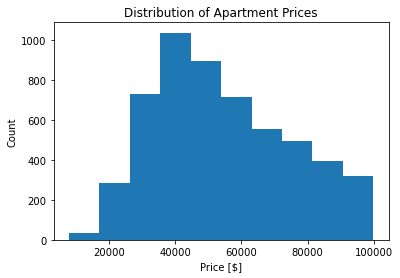

In [8]:
# Building histogram
plt.hist(df["price_aprox_usd"])
plt.xlabel("Price [$]")
plt.ylabel("Count")
plt.title("Distribution of Apartment Prices")

Insights: Distribution of Apt Prices are skewed right

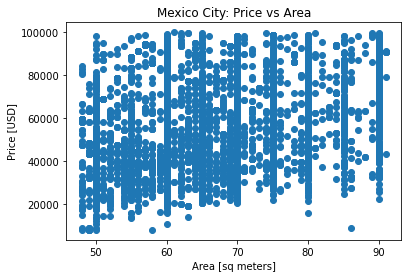

In [9]:
# Building scatter plot
x = df['surface_covered_in_m2']
y = df['price_aprox_usd']
plt.scatter(x,y)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Mexico City: Price vs Area");

Insights: Very weak correleation btwn. Price and Area

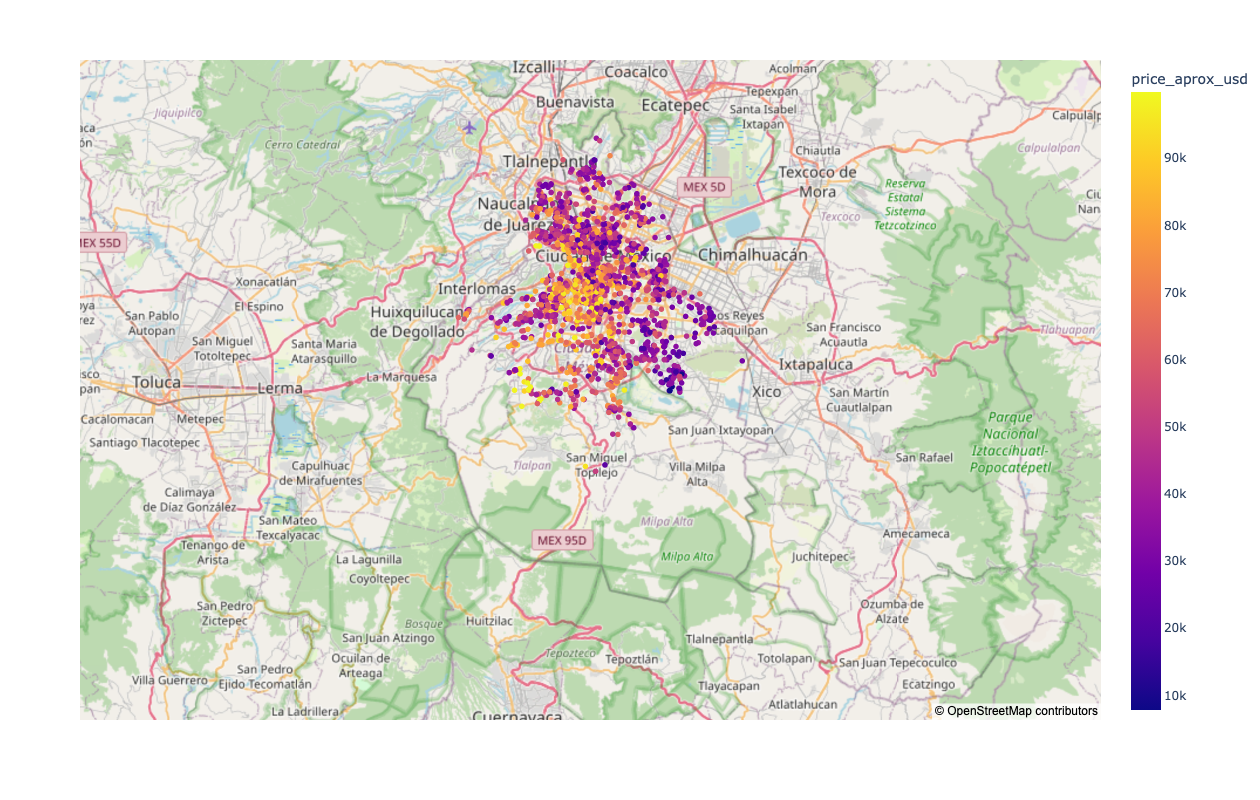

In [10]:
# Creating a Mapbox scatter plot to show the location of the apartments in the dataset and represent their price using color.
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat='lat',
    lon='lon',
    width=1000,  # Width of map
    height=800,  # Height of map
    color='price_aprox_usd',
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

Insights: More expensive apartments located in the strip running North to South from Miguel Hildalgo borough to Tlalpan borough

### Split

In [11]:
# Spliting the data into feature matrix `X_train` and target vector `y_train`.
target = "price_aprox_usd"
features = ["surface_covered_in_m2", "lat", "lon", "borough"]
y_train = df[target]
X_train = df[features]

## Build Model

In [12]:
# Calculating the baseline mean absolute error for the model. 
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.5314982642
Baseline MAE: 17239.939475888295


### Iterate

In [13]:
# Build Model with pipeline
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)

# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

### Evaluate

Note to self: make sure the X_train you used to train your model has the same column order as X_test. Otherwise, it may hurt your model's performance or code will not compile

In [14]:
# Removing price column (leakage variable)
df.drop(columns=df.columns[0], inplace=True)

# Saving the data frame above to a CSV file on local machine as the features for the model
df.to_csv("/Users/susiechen/Documents/Personal_Project_Data/WorldQuantUni/1_2_Mexico_real_estate/mexico-city-test-features.csv", index=False)

In [15]:
# Reading the Features CSV file into the Data Frame X_Test
X_test = pd.read_csv("/Users/susiechen/Documents/Personal_Project_Data/WorldQuantUni/1_2_Mexico_real_estate/mexico-city-test-features.csv")
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  5473 non-null   float64
 1   lat                    5149 non-null   float64
 2   lon                    5149 non-null   float64
 3   borough                5473 non-null   object 
dtypes: float64(3), object(1)
memory usage: 171.2+ KB
None


surface_covered_in_m2        lat        lon              borough
0                   75.0  19.362690 -99.150565        Benito Juárez
1                   62.0  19.291345 -99.124312              Tlalpan
2                   85.0  19.354987 -99.061709           Iztapalapa
3                   52.0  19.469681 -99.086136    Gustavo A. Madero
4                   53.0  19.443592 -99.121407  Venustiano Carranza

In [16]:
# Generating a Series of predictions for X_test. 
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    69032.039095
1    61682.180476
2    44596.236488
3    41799.041651
4    43193.616032
dtype: float64

## Communicate Results

In [17]:
# Creating a Series named feat_imp containing all feature names in the model, respective coeff. values, sorted ascending by absolute value. 
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names_out()
feat_imp = pd.Series(coefficients, index=features)
feat_imp_sorted = feat_imp.abs().sort_values()
feat_imp_sorted

surface_covered_in_m2               291.654156
borough_Cuauhtémoc                  350.531990
borough_Iztacalco                   405.403127
lat                                 478.901375
borough_Xochimilco                  929.857400
borough_Miguel Hidalgo             1977.314718
borough_Azcapotzalco               2459.288646
lon                                2492.221814
borough_Álvaro Obregón             3275.121061
borough_Coyoacán                   3737.561001
borough_Venustiano Carranza        5609.918629
borough_La Magdalena Contreras     5925.666450
borough_Gustavo A. Madero          6637.429757
borough_Cuajimalpa de Morelos      9157.269123
borough_Tlalpan                   10319.429804
borough_Iztapalapa                13349.017448
borough_Benito Juárez             13778.188880
borough_Tláhuac                   14166.869486
dtype: float64

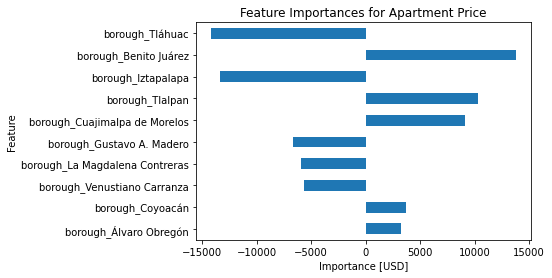

In [18]:
# Building a bar chart showing the 10 most influential coefficients for your model.
feat_imp.sort_values(key=abs).tail(10).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importances for Apartment Price");

New Concepts Learned:
- How to create a linear regression model using the scikit-learn library.
- How to build a data pipeline for imputing missing values and encoding categorical features.
- How to improve model performance by reducing overfitting.